<a href="https://colab.research.google.com/github/gommungommun/VCD/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

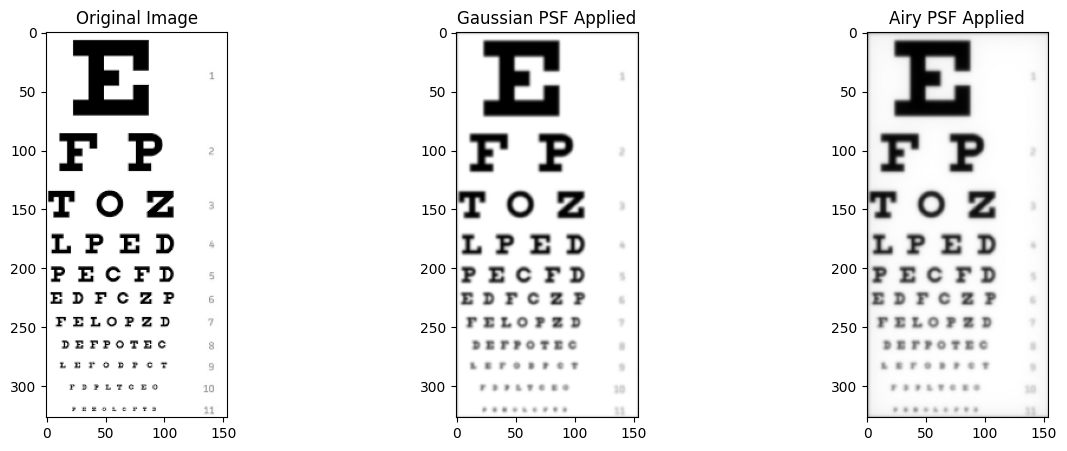

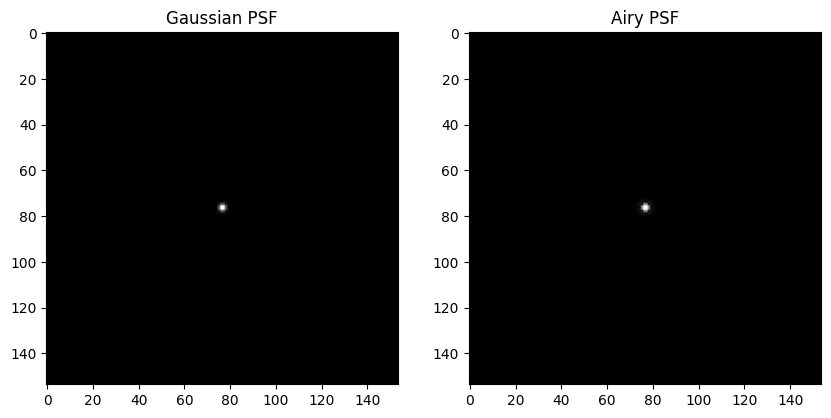

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy import special
from scipy.signal import convolve2d
import cv2

# PSF 함수들 (위에서 정의한 함수들 사용)
def gaussian_psf(size, sigma=3):
    if isinstance(size, tuple):
        h, w = filter_size(size)
    else:
        h = w = size
    x = np.linspace(-h/2, h/2, h)
    y = np.linspace(-w/2, w/2, w)
    x, y = np.meshgrid(x,y)

    pos = np.dstack((x,y))
    rv = multivariate_normal([0,0],[[sigma**2,0],[0,sigma**2]])
    psf = rv.pdf(pos)

    return psf/psf.sum()

def airy_psf(size, na=0.35,wavelength=550e-10):
    if isinstance(size, tuple):
        h, w = filter_size(size)
    else:
        h = w = size
    x = np.linspace(-h/2, h/2, w)
    y = np.linspace(-w/2, w/2, h)
    x, y = np.meshgrid(x, y)

    r = np.sqrt(x**2+y**2)
    k = 2*np.pi*na/wavelength

    psf = np.zeros_like(r)
    mask = r!=0
    psf[mask] = (2*special.j1(k*r[mask])/(k*r[mask]))**2
    psf[~mask] = 1

    return psf/psf.sum()

def filter_size(image_size):
  h, w = image_size
  filter_size = (min(max(min(h, w)//4, h),w), min(max(min(h, w)//4, h),w))
  return filter_size

test_image = cv2.imread('snellen.png', 0)
h, w = test_image.shape
#test_image = cv2.resize(test_image, (28,28))

# PSF 생성 - 필터의 사이즈를 적절히 조절해야 함
gaussian_filter = gaussian_psf((h, w), sigma=1)
airy_filter = airy_psf((h, w))



# 필터 적용
gaussian_result = convolve2d(test_image, gaussian_filter, mode='same')
airy_result = convolve2d(test_image, airy_filter, mode='same')

# 결과 정규화
gaussian_result = (gaussian_result - gaussian_result.min()) / (gaussian_result.max() - gaussian_result.min())
airy_result = (airy_result - airy_result.min()) / (airy_result.max() - airy_result.min())

# 결과 시각화
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(test_image, cmap='gray')
plt.title('Original Image')

plt.subplot(132)
plt.imshow(gaussian_result, cmap='gray')
plt.title('Gaussian PSF Applied')

plt.subplot(133)
plt.imshow(airy_result, cmap='gray')
plt.title('Airy PSF Applied')

plt.show()

# 필터 시각화
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(gaussian_filter, cmap='gray')
plt.title('Gaussian PSF')

plt.subplot(122)
plt.imshow(airy_filter, cmap='gray')
plt.title('Airy PSF')

plt.show()